<a href="https://colab.research.google.com/github/Lazarus-GS/NOMA-FYP-MATLAB/blob/main/ML%20Model/NOMAnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random Forest**

## 1. Data Loading and Preprocessing

In [ ]:
!pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 77.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
url = "https://raw.githubusercontent.com/Lazarus-GS/NOMA-FYP-MATLAB/main/New/optimal_ma_dataset.csv"
df_rf = pd.read_csv(url)

# Features and Target
X_rf = df_rf[["NearUserDist", "FarUserDist", "SNR"]]
y_rf = df_rf["OptimalMA"]

# Splitting the data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42)

## 2. Hyperparameter Tuning

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Hyperparameters grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True]
}

# Grid search with cross-validation
rf_grid = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, n_jobs=-1, verbose=2)
rf_grid.fit(X_train_rf, y_train_rf)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

## 3. Evaluation and Feature Importance

              precision    recall  f1-score   support

        NOMA       0.99      0.78      0.88      1087
         OMA       0.99      1.00      0.99     23019

    accuracy                           0.99     24106
   macro avg       0.99      0.89      0.94     24106
weighted avg       0.99      0.99      0.99     24106



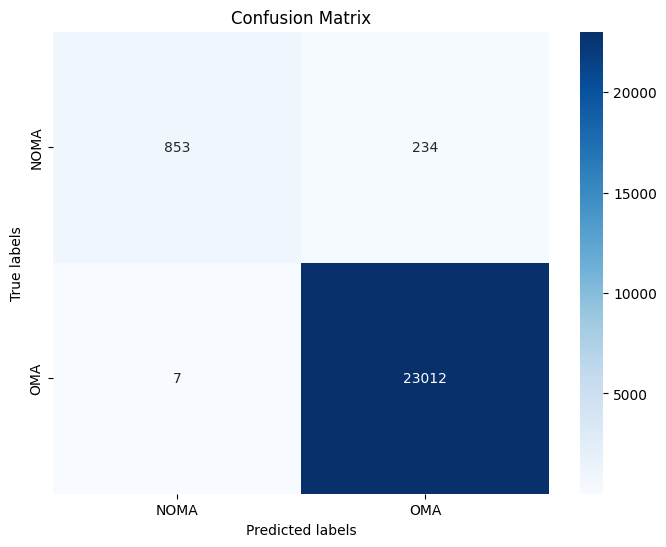

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions
y_pred_rf = rf_grid.predict(X_test_rf)

# Classification Report
print(classification_report(y_test_rf, y_pred_rf))

# Confusion Matrix Visualization
cm = confusion_matrix(y_test_rf, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=["NOMA", "OMA"], yticklabels=["NOMA", "OMA"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 4. Learning Curve

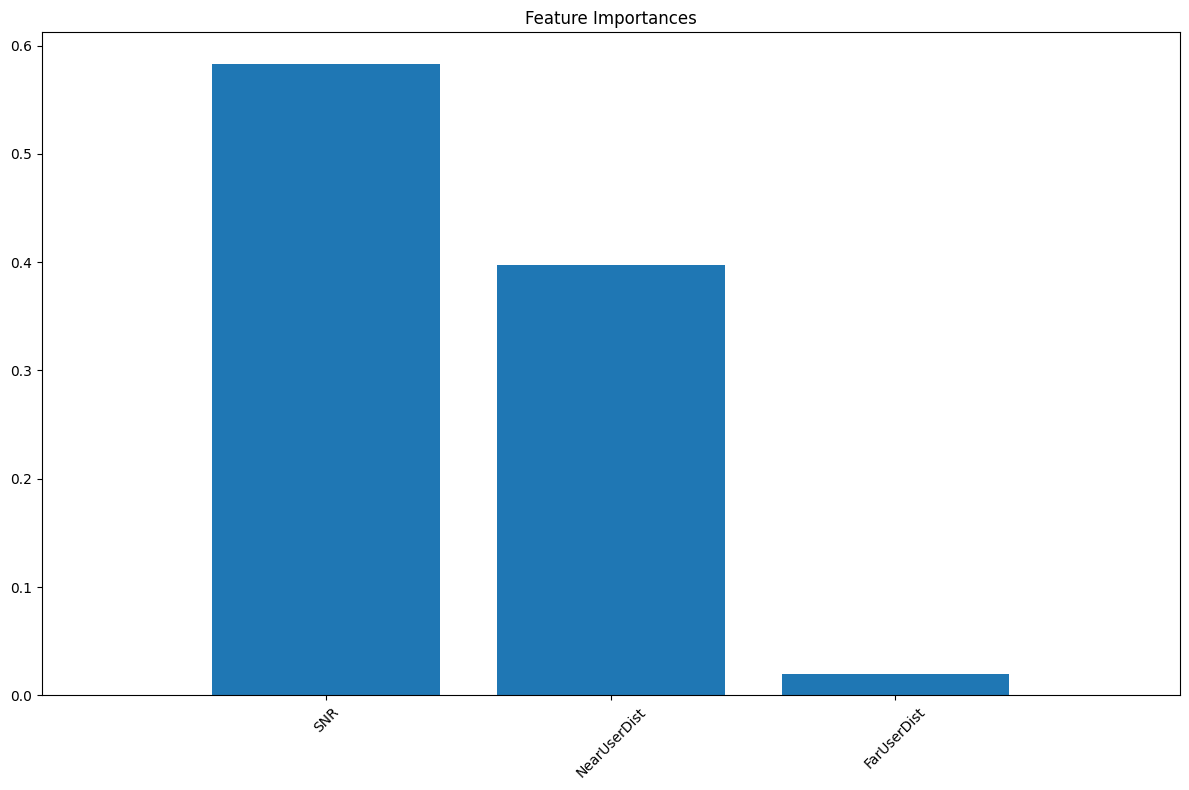

Best parameters found:  {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}


In [ ]:
import numpy as np

# Feature Importance Visualization
importances = rf_grid.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(range(X_train_rf.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_rf.shape[1]), X_train_rf.columns[indices], rotation=45)
plt.xlim([-1, X_train_rf.shape[1]])
plt.tight_layout()
plt.show()

# Best parameters
print("Best parameters found: ", rf_grid.best_params_)

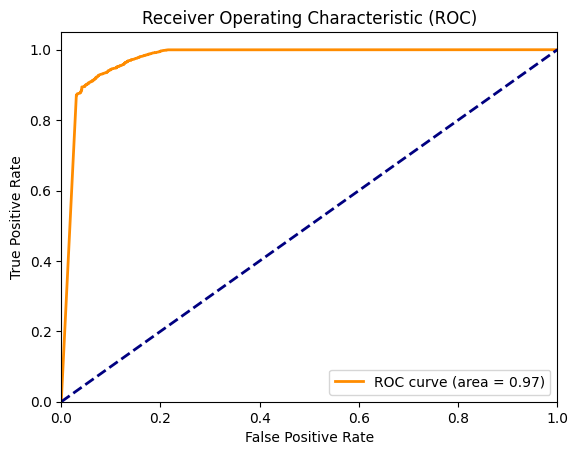

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test_rf, rf_grid.predict_proba(X_test_rf)[:,1], pos_label='OMA')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

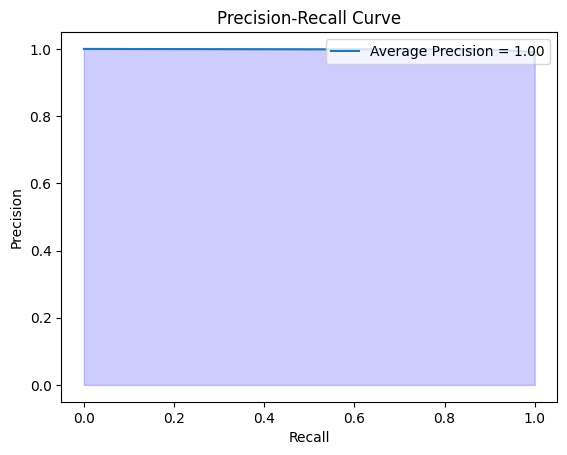

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test_rf, rf_grid.predict_proba(X_test_rf)[:,1], pos_label='OMA')
average_precision = average_precision_score(y_test_rf, rf_grid.predict_proba(X_test_rf)[:,1], pos_label='OMA')

plt.figure()
plt.plot(recall, precision, label='Average Precision = {0:0.2f}'.format(average_precision))
plt.fill_between(recall, precision, alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()

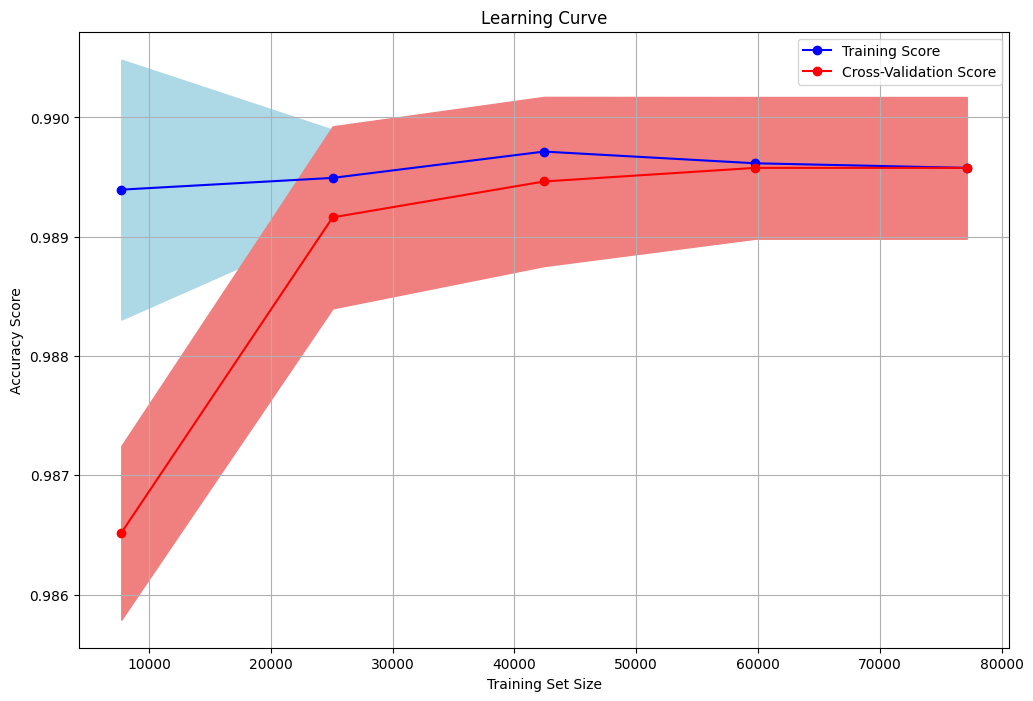

In [ ]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(rf_grid.best_estimator_, X_train_rf, y_train_rf, cv=5)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(12, 8))
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="lightblue")
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="lightcoral")
plt.plot(train_sizes, train_mean, 'o-', color="blue", label="Training Score")
plt.plot(train_sizes, test_mean, 'o-', color="red", label="Cross-Validation Score")
plt.title("Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy Score")
plt.legend(loc="best")
plt.grid()
plt.show()

In [ ]:
'''import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Convert positions to numerical values
df_rf['NearUserPos_num'] = df_rf['NearUserPos'].astype('category').cat.codes
df_rf['FarUserPos_num'] = df_rf['FarUserPos'].astype('category').cat.codes

# Create matrices for actual and predicted values
actual_matrix = np.zeros((df_rf['NearUserPos_num'].nunique(), df_rf['FarUserPos_num'].nunique()))
predicted_matrix = np.zeros((df_rf['NearUserPos_num'].nunique(), df_rf['FarUserPos_num'].nunique()))

for _, row in df_rf.iterrows():
    near_pos = row['NearUserPos_num']
    far_pos = row['FarUserPos_num']
    actual_value = 0 if row['OptimalMA'] == 'OMA' else 1
    predicted_value = 0 if rf_grid.predict([[row['NearUserDist'], row['FarUserDist'], row['SNR']]])[0] == 'OMA' else 1

    actual_matrix[near_pos, far_pos] = actual_value
    predicted_matrix[near_pos, far_pos] = predicted_value

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(actual_matrix, cmap="YlGnBu", cbar_kws={'label': 'OptimalMA'})
plt.title('Actual Optimal Multiple Access Schemes')
plt.xlabel('Far User Position')
plt.ylabel('Near User Position')
plt.show()

plt.figure(figsize=(12, 10))
sns.heatmap(predicted_matrix, cmap="YlGnBu", cbar_kws={'label': 'OptimalMA'})
plt.title('Predicted Optimal Multiple Access Schemes')
plt.xlabel('Far User Position')
plt.ylabel('Near User Position')
plt.show()'''

'import seaborn as sns\nimport matplotlib.pyplot as plt\nimport numpy as np\n\n# Convert positions to numerical values\ndf_rf[\'NearUserPos_num\'] = df_rf[\'NearUserPos\'].astype(\'category\').cat.codes\ndf_rf[\'FarUserPos_num\'] = df_rf[\'FarUserPos\'].astype(\'category\').cat.codes\n\n# Create matrices for actual and predicted values\nactual_matrix = np.zeros((df_rf[\'NearUserPos_num\'].nunique(), df_rf[\'FarUserPos_num\'].nunique()))\npredicted_matrix = np.zeros((df_rf[\'NearUserPos_num\'].nunique(), df_rf[\'FarUserPos_num\'].nunique()))\n\nfor _, row in df_rf.iterrows():\n    near_pos = row[\'NearUserPos_num\']\n    far_pos = row[\'FarUserPos_num\']\n    actual_value = 0 if row[\'OptimalMA\'] == \'OMA\' else 1\n    predicted_value = 0 if rf_grid.predict([[row[\'NearUserDist\'], row[\'FarUserDist\'], row[\'SNR\']]])[0] == \'OMA\' else 1\n\n    actual_matrix[near_pos, far_pos] = actual_value\n    predicted_matrix[near_pos, far_pos] = predicted_value\n\n# Plotting\nplt.figure(figsize=

In [ ]:
'''import matplotlib.pyplot as plt
import numpy as np

# Convert positions to numerical values
df_rf['NearUserPos_num'] = df_rf['NearUserPos'].astype('category').cat.codes
df_rf['FarUserPos_num'] = df_rf['FarUserPos'].astype('category').cat.codes

# Create matrices for actual and predicted values
actual_matrix = np.zeros((df_rf['NearUserPos_num'].nunique(), df_rf['FarUserPos_num'].nunique()))
predicted_matrix = np.zeros((df_rf['NearUserPos_num'].nunique(), df_rf['FarUserPos_num'].nunique()))

for _, row in df_rf.iterrows():
    near_pos = row['NearUserPos_num']
    far_pos = row['FarUserPos_num']
    actual_value = 0 if row['OptimalMA'] == 'OMA' else 1
    predicted_value = 0 if rf_grid.predict([[row['NearUserDist'], row['FarUserDist'], row['SNR']]])[0] == 'OMA' else 1

    actual_matrix[near_pos, far_pos] = actual_value
    predicted_matrix[near_pos, far_pos] = predicted_value

# Plotting
plt.figure(figsize=(12, 10))

# Plot actual values using contourf (filled contour)
plt.contourf(actual_matrix, alpha=0.6, cmap="YlGnBu", levels=2)

# Plot predicted values using contour (only lines)
contour = plt.contour(predicted_matrix, colors='k', linewidths=0.5)
plt.clabel(contour, inline=1, fontsize=10)

plt.title('Overlay of Actual and Predicted Optimal Multiple Access Schemes')
plt.xlabel('Far User Position')
plt.ylabel('Near User Position')
plt.colorbar(label='OptimalMA')
plt.show()'''

'import matplotlib.pyplot as plt\nimport numpy as np\n\n# Convert positions to numerical values\ndf_rf[\'NearUserPos_num\'] = df_rf[\'NearUserPos\'].astype(\'category\').cat.codes\ndf_rf[\'FarUserPos_num\'] = df_rf[\'FarUserPos\'].astype(\'category\').cat.codes\n\n# Create matrices for actual and predicted values\nactual_matrix = np.zeros((df_rf[\'NearUserPos_num\'].nunique(), df_rf[\'FarUserPos_num\'].nunique()))\npredicted_matrix = np.zeros((df_rf[\'NearUserPos_num\'].nunique(), df_rf[\'FarUserPos_num\'].nunique()))\n\nfor _, row in df_rf.iterrows():\n    near_pos = row[\'NearUserPos_num\']\n    far_pos = row[\'FarUserPos_num\']\n    actual_value = 0 if row[\'OptimalMA\'] == \'OMA\' else 1\n    predicted_value = 0 if rf_grid.predict([[row[\'NearUserDist\'], row[\'FarUserDist\'], row[\'SNR\']]])[0] == \'OMA\' else 1\n\n    actual_matrix[near_pos, far_pos] = actual_value\n    predicted_matrix[near_pos, far_pos] = predicted_value\n\n# Plotting\nplt.figure(figsize=(12, 10))\n\n# Plot act

In [ ]:
# Sample input data
data = {
    'NearUserDist': [1, 1],
    'FarUserDist': [20, 1000],
    'SNR': [10, -28]
}

# Convert to DataFrame
input_df_rf = pd.DataFrame(data)

# Make predictions using the trained model
predicted_schemes = rf_grid.predict(input_df_rf)

print(predicted_schemes)

['OMA' 'OMA']


# **GBM**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# 1. Data Loading and Preparation
url1 = "https://raw.githubusercontent.com/Lazarus-GS/NOMA-FYP-MATLAB/main/New/optimal_ma_dataset.csv"
df_gbm = pd.read_csv(url1)

# Splitting the data
features = ["NearUserDist", "FarUserDist", "SNR"]
X_gbm = df_gbm[features]
y_gbm = df_gbm["OptimalMA"]

X_train_gbm, X_test_gbm, y_train_gbm, y_test_gbm = train_test_split(X_gbm, y_gbm, test_size=0.2, random_state=42)

In [ ]:
# 2. Hyperparameter Tuning
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [3, 4, 5, 6],
    'subsample': [0.8, 0.9, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

gbm = GradientBoostingClassifier()
gbm_grid = GridSearchCV(gbm, param_grid, cv=5, n_jobs=-1, verbose=2)
gbm_grid.fit(X_train_gbm, y_train_gbm)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'max_depth': [3, 4, 5, 6],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [50, 100, 200],
                         'subsample': [0.8, 0.9, 1.0]},
             verbose=2)

              precision    recall  f1-score   support

        NOMA       0.99      0.78      0.88      1087
         OMA       0.99      1.00      0.99     23019

    accuracy                           0.99     24106
   macro avg       0.99      0.89      0.94     24106
weighted avg       0.99      0.99      0.99     24106



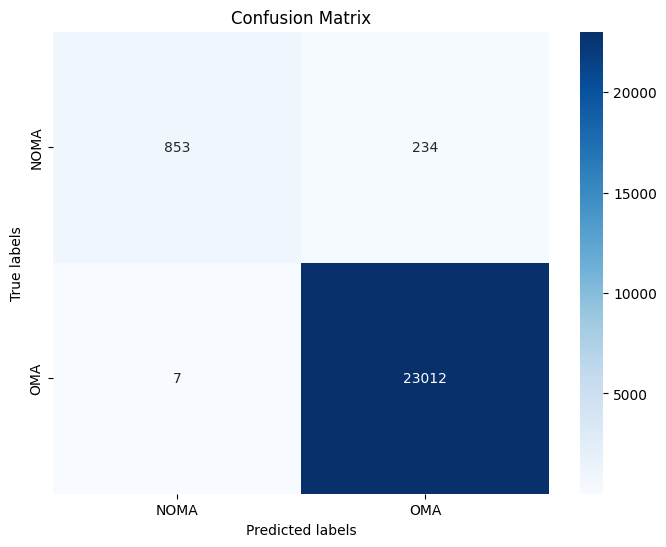

In [ ]:
# 3. Model Evaluation
y_pred_gbm = gbm_grid.predict(X_test_gbm)
print(classification_report(y_test_gbm, y_pred_gbm))

# Confusion matrix visualization
conf_matrix = confusion_matrix(y_test_gbm, y_pred_gbm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=["NOMA", "OMA"], yticklabels=["NOMA", "OMA"])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

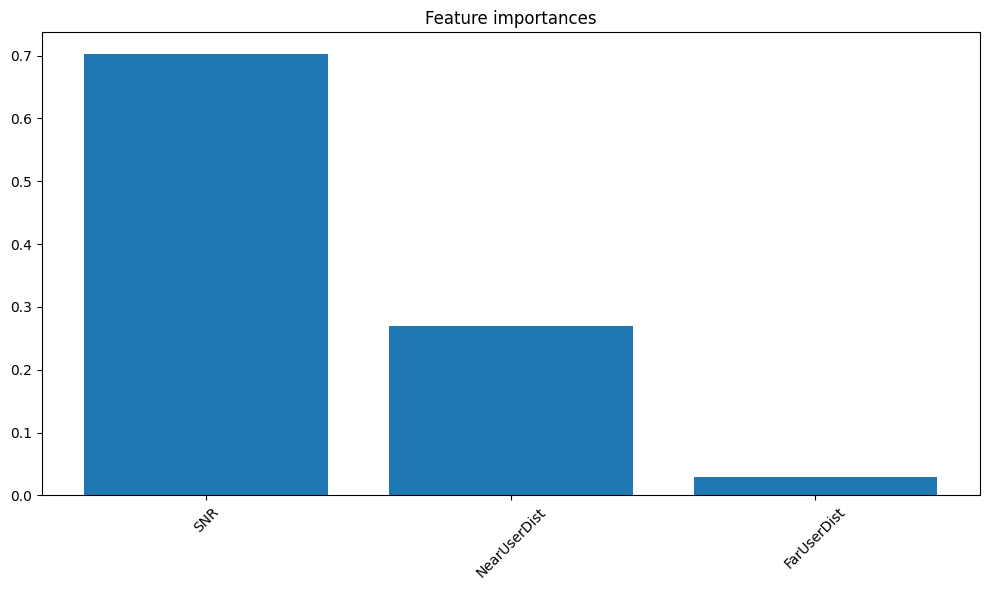

In [ ]:
# 4. Visualization - Feature Importance
feature_importance = gbm_grid.best_estimator_.feature_importances_
indices = np.argsort(feature_importance)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(X_gbm.columns[indices], feature_importance[indices], align="center")
plt.xticks(X_gbm.columns[indices], rotation=45)
plt.tight_layout()
plt.show()

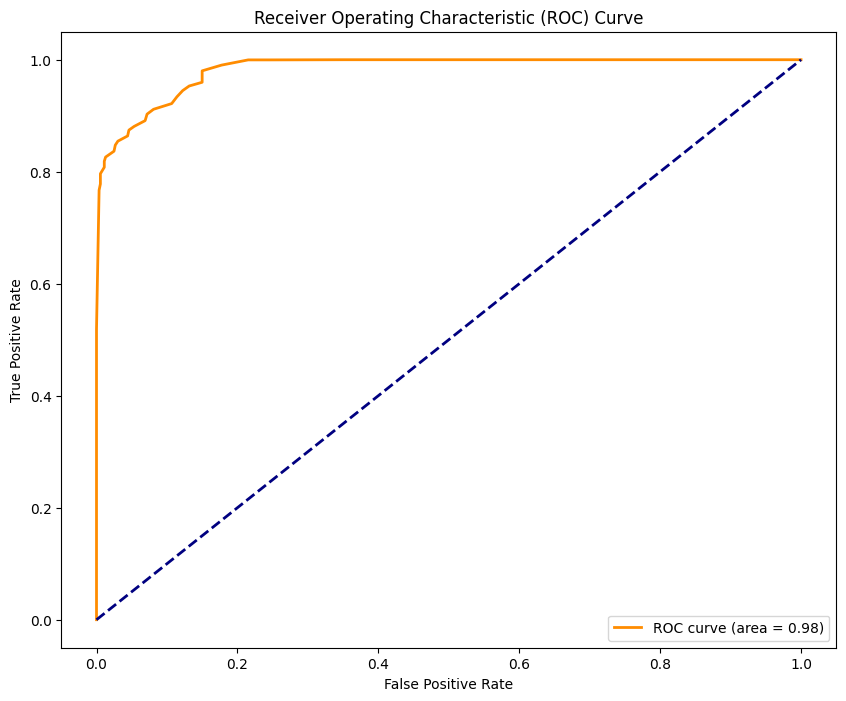

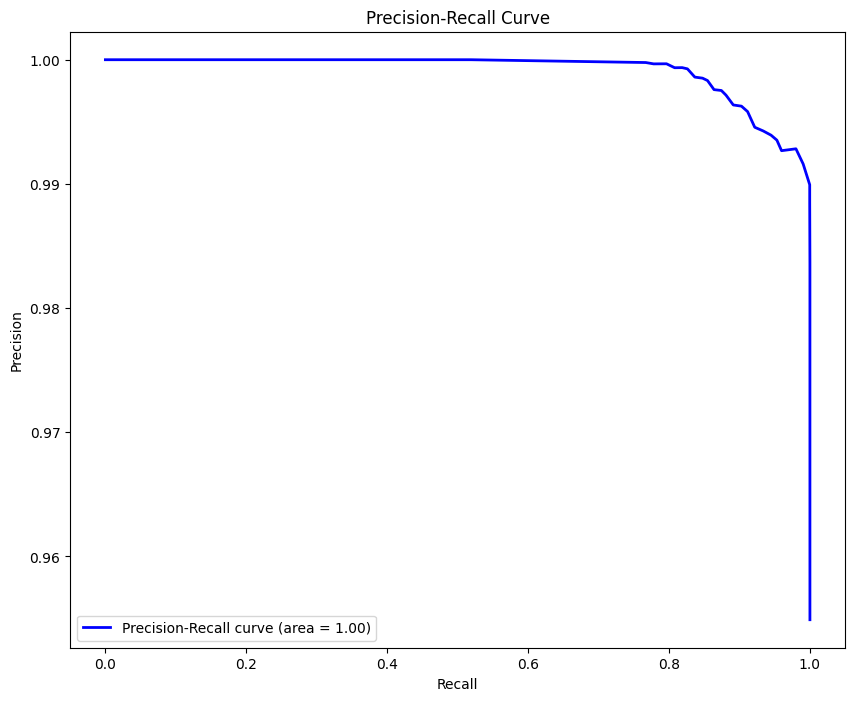

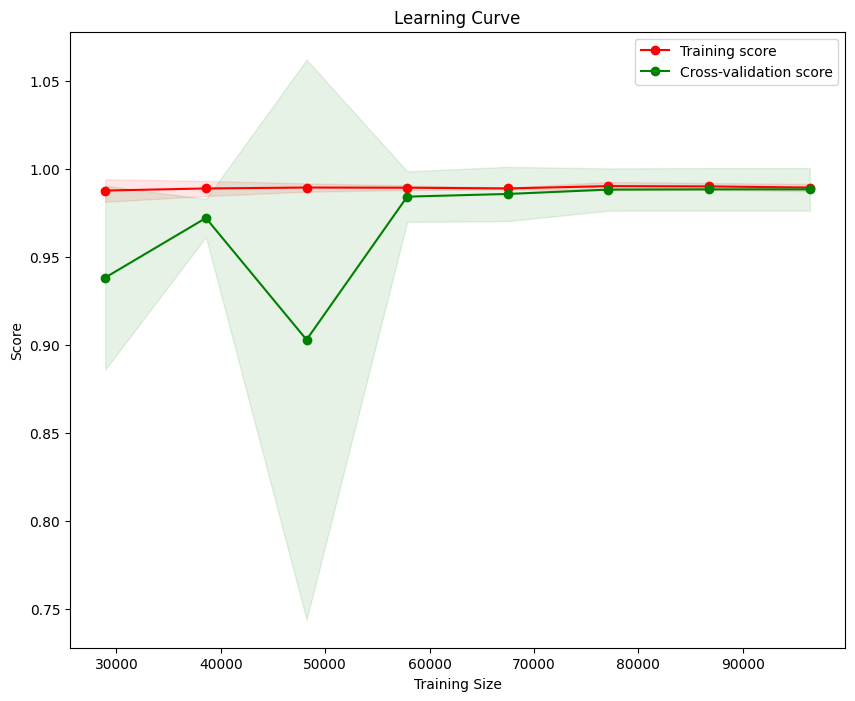

In [ ]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_gbm, gbm_grid.predict_proba(X_test_gbm)[:,1], pos_label="OMA")
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_gbm, gbm_grid.predict_proba(X_test_gbm)[:,1], pos_label="OMA")
average_precision = average_precision_score(y_test_gbm, gbm_grid.predict_proba(X_test_gbm)[:,1], pos_label="OMA")
plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % average_precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()

# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(gbm_grid.best_estimator_, X_gbm, y_gbm, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()

In [ ]:
# Sample input data
data = {
    'NearUserDist': [35.35, 25.50],
    'FarUserDist': [77.78, 60.20],
    'SNR': [-30, -28]
}

# Convert to DataFrame
input_df_gbm = pd.DataFrame(data)

# Use the best GBM model from GridSearchCV to make predictions
predicted_schemes = gbm_grid.best_estimator_.predict(input_df_gbm)

print(predicted_schemes)

['OMA' 'OMA']


# **ANN**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelBinarizer

# Load the data
url2 = "https://raw.githubusercontent.com/Lazarus-GS/NOMA-FYP-MATLAB/main/New/optimal_ma_dataset.csv"
df_ann = pd.read_csv(url2)

# Select features and target
X_ann = df_ann[["NearUserDist", "FarUserDist", "SNR"]].values
y_ann = df_ann["OptimalMA"].values

# One-hot encode the target variable
lb = LabelBinarizer()
y_ann = lb.fit_transform(y_ann)

# Split the data
X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(X_ann, y_ann, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_ann = scaler.fit_transform(X_train_ann)
X_test_ann = scaler.transform(X_test_ann)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Build the model
model = Sequential()
model.add(Dense(128, input_dim=X_train_ann.shape[1], activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_ann.shape[1], activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
history = model.fit(
    X_train_ann, y_train_ann,
    validation_data=(X_test_ann, y_test_ann),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
3014/3014 [==============================] - 12s 3ms/step - loss: 0.1128 - accuracy: 0.9702 - val_loss: 0.0550 - val_accuracy: 0.9834
Epoch 2/100
  74/3014 [..............................] - ETA: 6s - loss: 0.0782 - accuracy: 0.9818

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3014/3014 [==============================] - 7s 2ms/step - loss: 0.0710 - accuracy: 0.9792 - val_loss: 0.0493 - val_accuracy: 0.9861
Epoch 3/100
3014/3014 [==============================] - 9s 3ms/step - loss: 0.0626 - accuracy: 0.9813 - val_loss: 0.0490 - val_accuracy: 0.9856
Epoch 4/100
3014/3014 [==============================] - 9s 3ms/step - loss: 0.0583 - accuracy: 0.9826 - val_loss: 0.0474 - val_accuracy: 0.9865
Epoch 5/100
3014/3014 [==============================] - 7s 2ms/step - loss: 0.0557 - accuracy: 0.9838 - val_loss: 0.0418 - val_accuracy: 0.9886
Epoch 6/100
3014/3014 [==============================] - 9s 3ms/step - loss: 0.0539 - accuracy: 0.9844 - val_loss: 0.0425 - val_accuracy: 0.9886
Epoch 7/100
3014/3014 [==============================] - 7s 2ms/step - loss: 0.0527 - accuracy: 0.9844 - val_loss: 0.0430 - val_accuracy: 0.9886
Epoch 8/100
3014/3014 [==============================] - 8s 3ms/step - loss: 0.0522 - accuracy: 0.9846 - val_loss: 0.0418 - val_accuracy: 0.98

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test_ann, y_test_ann)
print(f"Test Accuracy: {accuracy*100:.2f}%")

754/754 [==============================] - 1s 2ms/step - loss: 0.0412 - accuracy: 0.9886
Test Accuracy: 98.86%


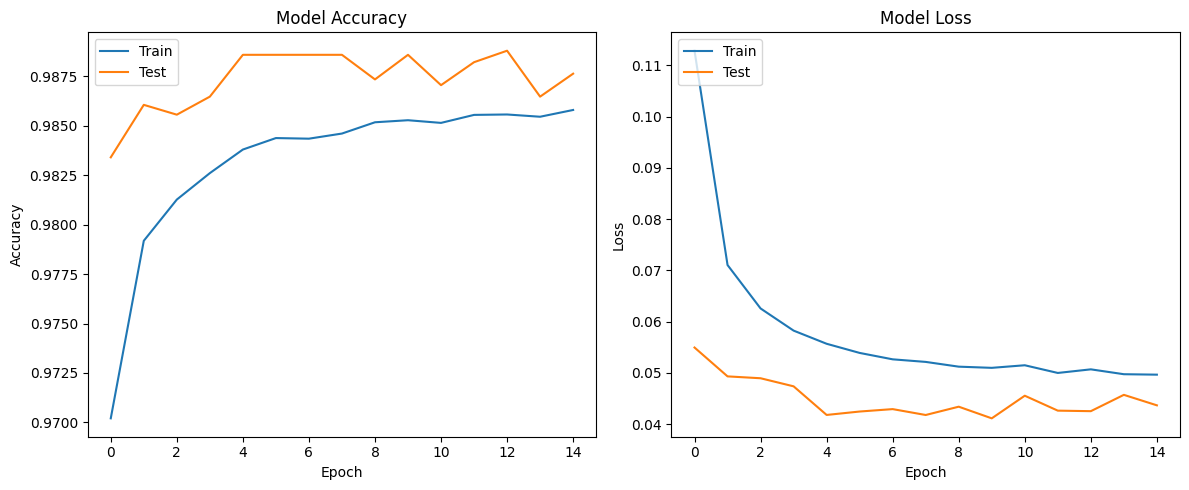

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.tight_layout()
plt.show()

754/754 [==============================] - 1s 1ms/step


<Figure size 800x600 with 0 Axes>

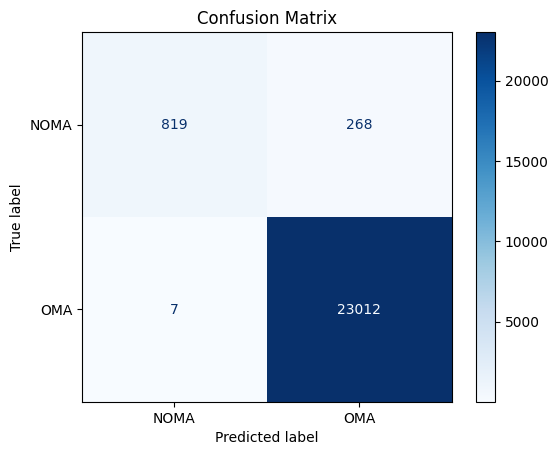

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict classes
y_pred_ann = model.predict(X_test_ann)
y_pred_ann_classes = (y_pred_ann > 0.5).astype(int)
y_true_classes_ann = y_test_ann

# Plot the confusion matrix
cm = confusion_matrix(y_true_classes_ann, y_pred_ann_classes)
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lb.classes_).plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

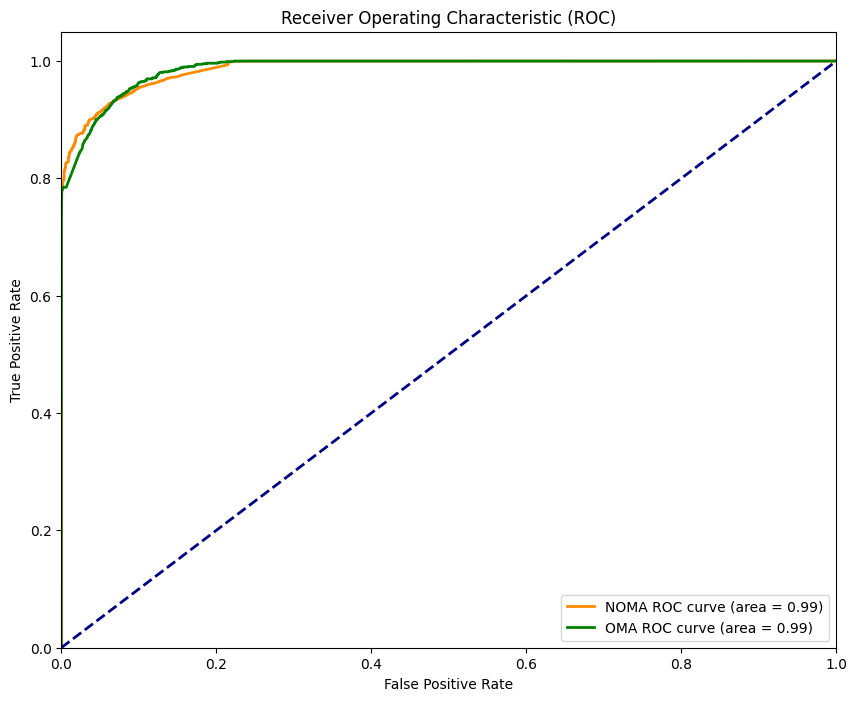

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Flatten y_test_ann to 1D
y_true_flat = y_test_ann.flatten()

# Extract predicted probabilities for 'NOMA'
y_pred_ann_noma = y_pred_ann[:, 0]

# Calculate ROC curve for 'NOMA'
fpr_noma, tpr_noma, thresholds_noma = roc_curve(y_true_flat, y_pred_ann_noma)
roc_auc_noma = auc(fpr_noma, tpr_noma)

# Calculate ROC curve for 'OMA' by inverting the true labels and predictions
fpr_oma, tpr_oma, thresholds_oma = roc_curve(1 - y_true_flat, 1 - y_pred_ann_noma)
roc_auc_oma = auc(fpr_oma, tpr_oma)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_noma, tpr_noma, color='darkorange', lw=2, label='NOMA ROC curve (area = %0.2f)' % roc_auc_noma)
plt.plot(fpr_oma, tpr_oma, color='green', lw=2, label='OMA ROC curve (area = %0.2f)' % roc_auc_oma)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred_ann_labels = np.where(y_pred_ann_noma >= 0.5, 'NOMA', 'OMA')

# Convert the binary encoded true labels back to their string representations
y_true_labels = np.where(y_true_flat == 1, 'NOMA', 'OMA')

# Get classification report
report = classification_report(y_true_labels, y_pred_ann_labels, target_names=['OMA', 'NOMA'])

print(report)

              precision    recall  f1-score   support

         OMA       0.99      1.00      0.99     23019
        NOMA       0.99      0.75      0.86      1087

    accuracy                           0.99     24106
   macro avg       0.99      0.88      0.93     24106
weighted avg       0.99      0.99      0.99     24106



# **Performance Comparison**

754/754 [==============================] - 1s 1ms/step
ANN Accuracy: 0.9885920517713432
GBM Accuracy: 0.9900024890068863
Random Forest Accuracy: 0.9900024890068863


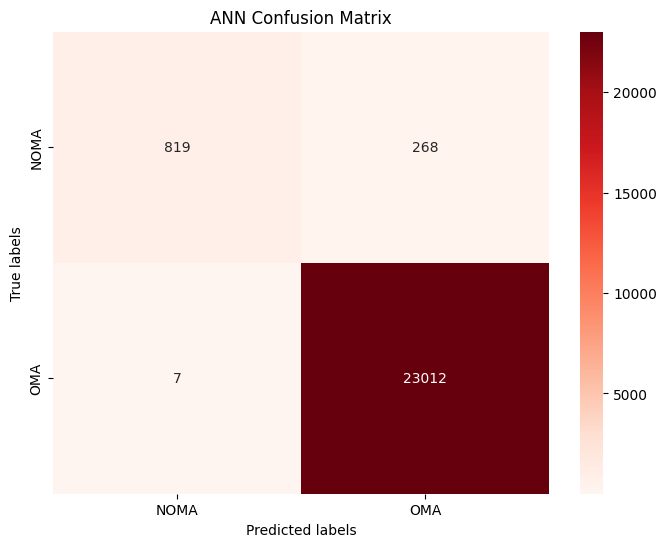

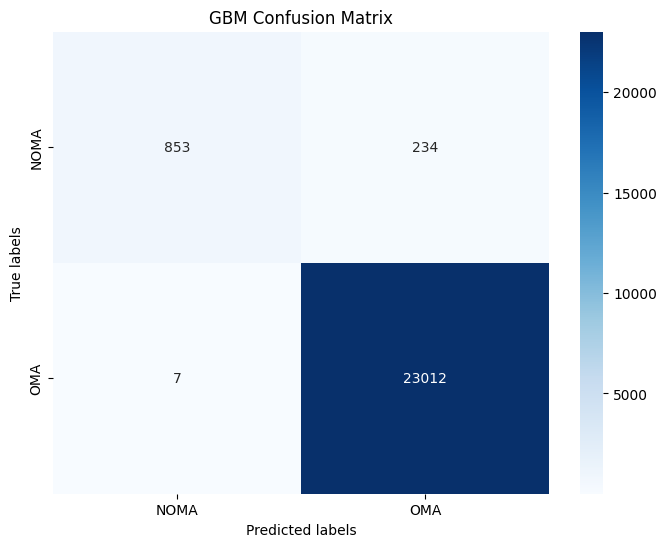

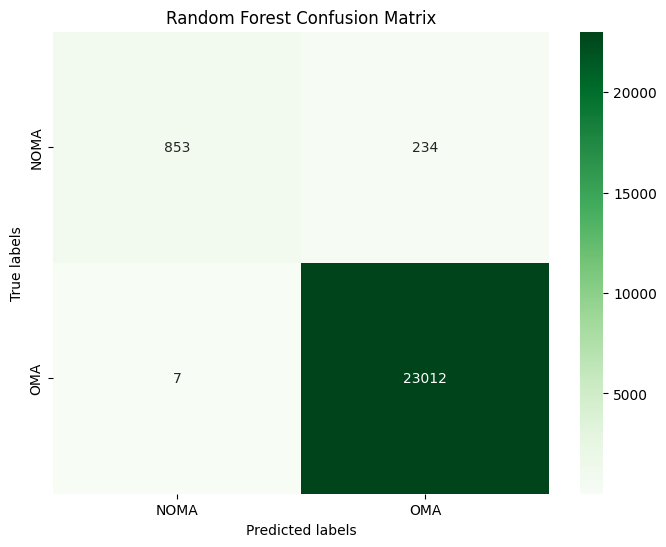

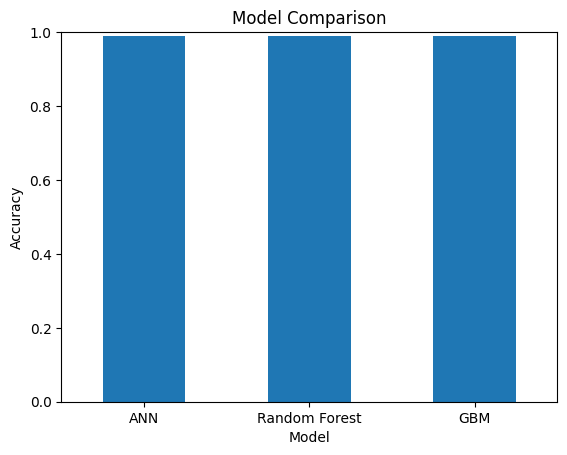

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Evaluate ANN
ann_predictions = model.predict(X_test_ann)
ann_predictions = (ann_predictions > 0.5).astype(int)  # Convert to 0s and 1s based on threshold
ann_accuracy = accuracy_score(y_test_ann, ann_predictions)

# 2. Evaluate GBM
gbm_predictions = gbm_grid.predict(X_test_gbm)
gbm_accuracy = accuracy_score(y_test_gbm, gbm_predictions)

# 3. Evaluate Random Forest
rf_predictions = rf_grid.predict(X_test_rf)
rf_accuracy = accuracy_score(y_test_rf, rf_predictions)

# 4. Print Accuracies
print("ANN Accuracy:", ann_accuracy)
print("GBM Accuracy:", gbm_accuracy)
print("Random Forest Accuracy:", rf_accuracy)

# 5. Plot Confusion Matrices

# For ANN
conf_matrix_ann = confusion_matrix(y_test_ann, ann_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ann, annot=True, fmt='g', cmap='Reds', xticklabels=["NOMA", "OMA"], yticklabels=["NOMA", "OMA"])
plt.title('ANN Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# For GBM
conf_matrix_gbm = confusion_matrix(y_test_gbm, gbm_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_gbm, annot=True, fmt='g', cmap='Blues', xticklabels=["NOMA", "OMA"], yticklabels=["NOMA", "OMA"])
plt.title('GBM Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# For Random Forest
conf_matrix_rf = confusion_matrix(y_test_rf, rf_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='g', cmap='Greens', xticklabels=["NOMA", "OMA"], yticklabels=["NOMA", "OMA"])
plt.title('Random Forest Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

# 6. Visual comparison of Accuracies
data = {
    'Model': ['ANN', 'Random Forest', 'GBM'],
    'Accuracy': [ann_accuracy, rf_accuracy, gbm_accuracy]
}
df_comparison = pd.DataFrame(data)

df_comparison.plot(x='Model', kind='bar', title='Model Comparison', legend=False)
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.show()


In [ ]:
comparison_data = {
    'Model': ['Random Forest', 'GBM', 'ANN'],
    'Accuracy': [rf_accuracy, gbm_accuracy, ann_accuracy],
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df)

           Model  Accuracy
0  Random Forest  0.990002
1            GBM  0.990002
2            ANN  0.988592


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score

# Load the test dataset from GitHub
urlt = "https://raw.githubusercontent.com/Lazarus-GS/NOMA-FYP-MATLAB/main/New/highest_scored_MA_schemes_grid8.csv"
test_data = pd.read_csv(urlt)

# Extracting features and labels from the test dataset
X_new_test = test_data[["NearUserDist", "FarUserDist", "SNR"]]
y_new_test = test_data["OptimalMA"]

gbm_predictions_new = gbm_grid.predict(X_new_test)
rf_predictions_new = rf_grid.predict(X_new_test)


gbm_accuracy_new = accuracy_score(y_new_test, gbm_predictions_new)
rf_accuracy_new = accuracy_score(y_new_test, rf_predictions_new)

y_new_test = y_new_test.replace({"NOMA": 1, "OMA": 0})


ann_predictions_new = model.predict(X_new_test)
ann_predictions_new = (ann_predictions_new > 0.5).astype(int)
ann_accuracy_new = accuracy_score(y_new_test, ann_predictions_new)


print("ANN Accuracy on new test data:", ann_accuracy_new)
print("GBM Accuracy on new test data:", gbm_accuracy_new)
print("Random Forest Accuracy on new test data:", rf_accuracy_new)

744/744 [==============================] - 1s 1ms/step
ANN Accuracy on new test data: 0.15969422043010753
GBM Accuracy on new test data: 0.9888272849462365
Random Forest Accuracy on new test data: 0.9888272849462365
